In [52]:
library(tidymodels)
library(tidyverse)
library(repr)
library(readxl)
library(themis)
options(repr.matrix.max.rows = 6)

# Predicting Newsletter Subscription in Minecraft Players Using Age and Gameplay Hours

**Introduction:**

The Pacific Laboratory for Artificial Intelligence (PLAI) research group in Computer Science at the University of British Columbia (UBC), led by Frank Wood, has developed a Minecraft server that records player behaviour to understand how people play video games. Managing this system involves ensuring server stability and cost-effective recruitment strategies for ongoing research. Understanding which player characteristics predict engagement (such as newsletter subscription) is essential for their efforts. Therefore, in this analysis, we try to answer the question: **Can a player’s age and played hours predict whether they subscribe to the newsletter?**

To try and answer this question, we will use one data set that contain the following columns:

- `experience` (character type): The player's experience level (Beginner/Amateur/Regular/Pro/Veteran)
- `subscribe` (logical type): Whether the player subscribed to the newsletter (TRUE/FALSE)
- `hashedEmail` (character type): Unique identifier for a player
- `played_hours` (double type): Total hours the player spent in-game
- `name` (character type): The player's name
- `gender` (character type): The player's gender
- `Age` (double type): Age of the player (in years)

The player dataset has **196 rows and 7 columns**. 

**Methods and Results:**

First, we need to load the file.

In [78]:
player_data <- read_csv("players.csv")

player_data

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


To proceed with our analysis, we must tidy our data. Since we will be using a nearest neighbours classification, we do not want many predictors, since it could potentially slow our analysis (or even negatively affect it). Therefore, we select the `Age` and `played_hours` columns, since they are the only ones with integer values. We should also change our categorical variables to factors. Here, we must carefully consider missing values (the `drop_na` function can deal with them).

In [39]:
#this cell tidies the data and redies it to be analyzed and made into a vizualization and model

player_data_clean_0 <- select(player_data, -hashedEmail) |>
    select(-name) |>
  mutate(subscribe = as.factor(subscribe),
    gender = as.factor(gender),
    experience = as.factor(experience))

player_data_clean <- player_data_clean_0 |>
select(subscribe, played_hours, Age)|>
drop_na()

player_data_clean

subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
TRUE,30.3,9
TRUE,3.8,17
FALSE,0.0,17
⋮,⋮,⋮
FALSE,0.3,22
FALSE,0.0,17
FALSE,2.3,17


After selecting the needed columns, we can analyze the relationship between the variables and the predictor. We can look at their relationships all at once or separately. Below, visualizations of all these relationships:

Two histograms were made to observe whether age and hours played really affected a subscription status (figures 1.0 and 1.1). Figure 1.0 showed that those within the range of roughly 15 to 27 years of age seem to subscribe more, and Figure 1.1 showed that those with more hours have more subscriptions (even though there is a large number of people who subscribed with few hours, those with many hours were all subscribed).

Lastly, a scatter plot was made to show the relationship between all the predictors and the variable being predicted (Figure 1.2), which is the fusion of patterns from both Figure 1.0 and 1.1.

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


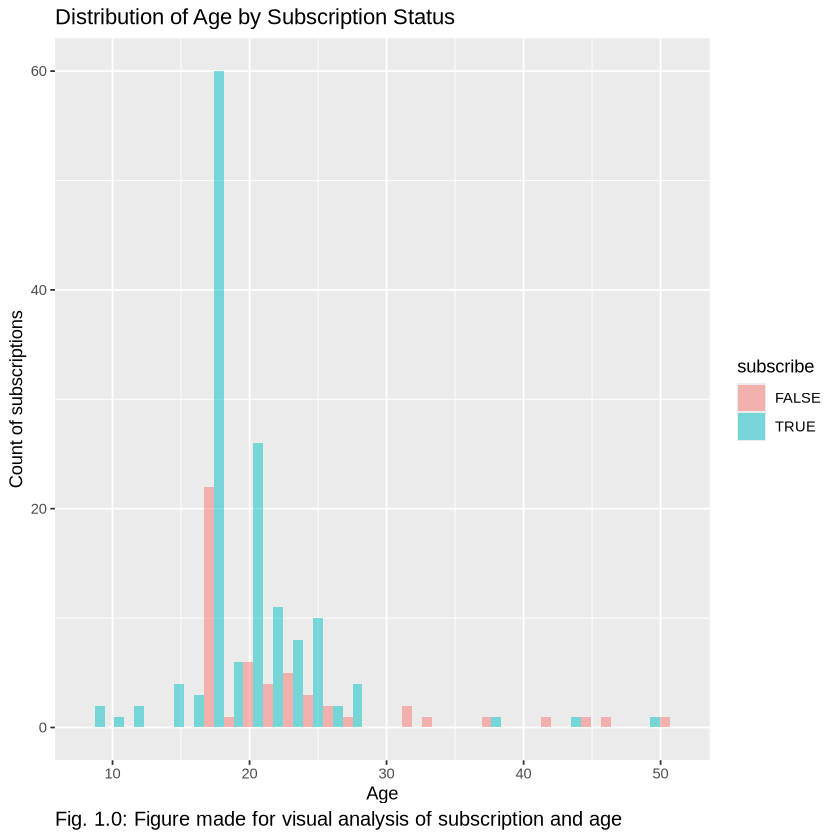

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


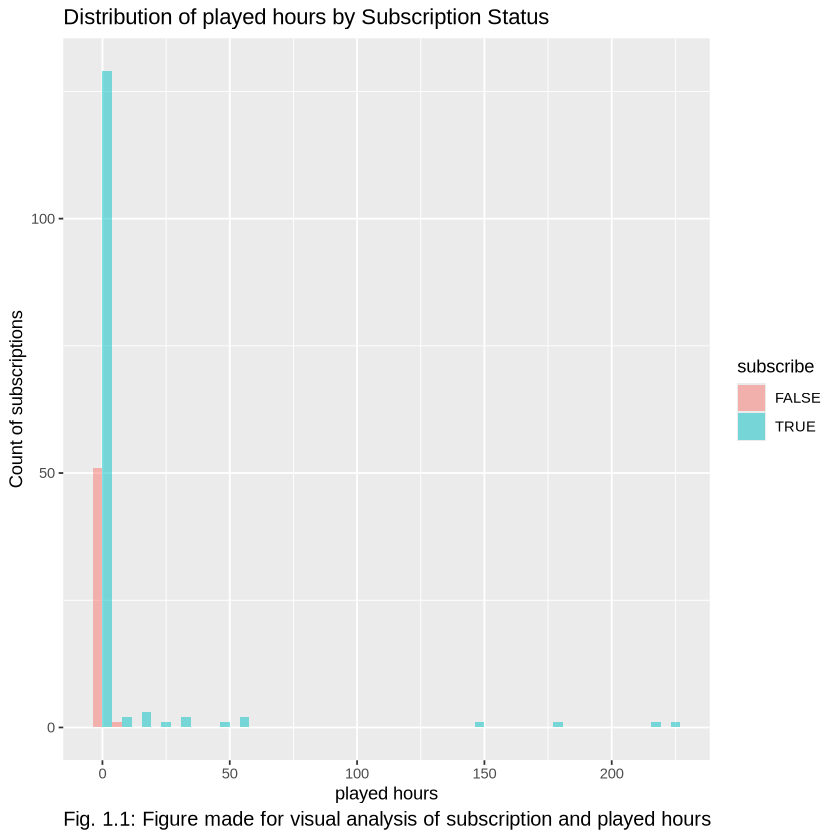

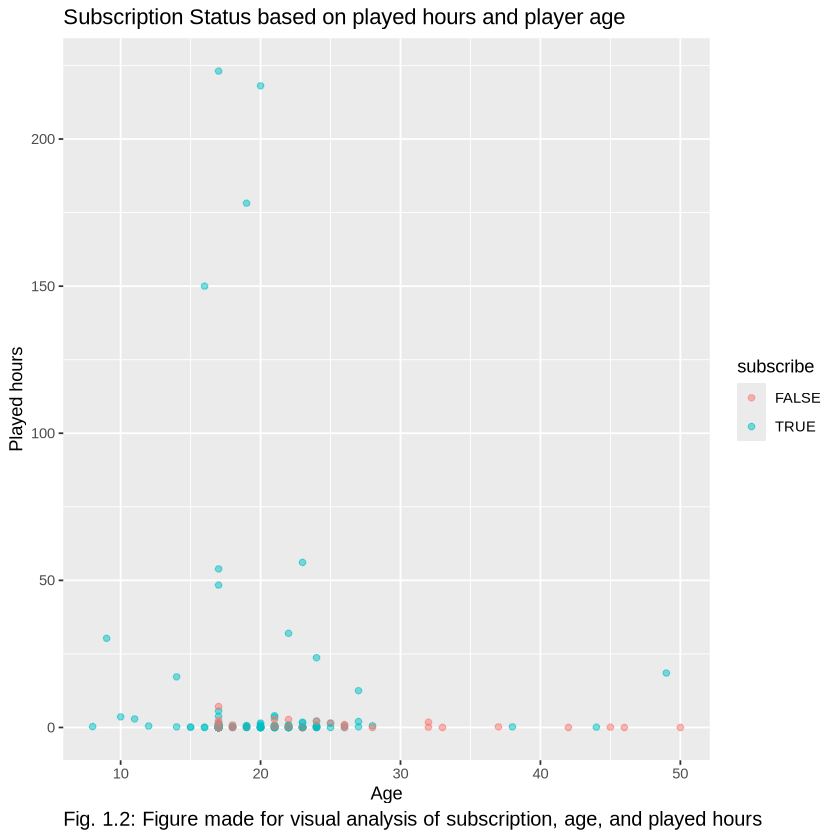

In [72]:
#this cell makes the important visualizations showing relation ships between variables and subscription

player_histogram <- ggplot(player_data, aes(x = Age, fill = subscribe)) +
  geom_histogram(position = "dodge", alpha = 0.5, bins = 30) +
  labs(title = "Distribution of Age by Subscription Status",
       x = "Age", y = "Count of subscriptions", 
       caption = "Fig. 1.0: Figure made for visual analysis of subscription and age") +
  theme(plot.caption = element_text(size = 12, hjust = 0))

player_histogram_hours <- ggplot(player_data, aes(x = played_hours, fill = subscribe)) +
  geom_histogram(position = "dodge", alpha = 0.5, bins = 30) +
  labs(title = "Distribution of played hours by Subscription Status",
       x = "played hours", y = "Count of subscriptions", 
       caption = "Fig. 1.1: Figure made for visual analysis of subscription and played hours") +
  theme(plot.caption = element_text(size = 12, hjust = 0))

player_scatter <- ggplot(player_data, aes(x = Age, y = played_hours, color = subscribe)) +
  geom_point(alpha = 0.5) +
  labs(title = "Subscription Status based on played hours and player age",
       x = "Age", y = "Played hours", 
       caption = "Fig. 1.2: Figure made for visual analysis of subscription, age, and played hours") +
  theme(plot.caption = element_text(size = 12, hjust = 0))

player_histogram
player_histogram_hours
player_scatter

I used K-Nearest Neighbours (KNN) classification to model subscription behaviour. This model was chosen because it is intuitive, requires few assumptions, and works well with nonlinear relationships. However, this method may not predict well beyond the range of values input in your training data and may not perform well with a large number of predictors. For it to work, the model assumes that similar players have similar labels.

For this model, I first split the data into training and testing data (with a 75/25 train-test split), then created the folds for cross validation (here I performed a 5-fold cross validation). 

Using the training data from the split, I created a recipe that scales the data and a specification for the KNN model that included tuning for the number of neighbours, all of which were then assembled into a workflow to determine the number of neighbours with the highest accuracy. 

In [74]:
set.seed(23)
# This cell is for the KNN classification model for the prediction of subscriptions

player_data_clean <- player_data_clean |>
  mutate(age = scale(Age),
    hours = scale(played_hours))

# Split the data into training and testing sets
data_split <- initial_split(player_data_clean, prop = 0.75, strata = subscribe)
train_data <- training(data_split)
test_data  <- testing(data_split)

# Create the folds for cross-validation
folds <- vfold_cv(train_data, v = 5, strata = subscribe)

#Create a table with k values
k_vals <- tibble(neighbors = seq(from = 1, to = 15, by = 1))

# Create a recipe
knn_recipe <- recipe(subscribe ~ age + hours, data = train_data) |>
  step_center(all_predictors()) |>
  step_scale(all_predictors())

# Specify the model
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

# Create a workflow and use tune grid
knn_workflow <- workflow() |>
  add_recipe(knn_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = folds, grid = k_vals) |>
  collect_metrics()

#find the best K to use in the model
accuracies <- knn_workflow |>
          filter(.metric == "accuracy") 
          
best_k <- accuracies |> 
          slice_max(mean, n = 1) |>
          pull(neighbors)
best_k

[1] 15

The number of neighbours was determined to be 15. This can also be visualized with the help of a line graph (Figure 2.0) that shows the accuracy versus the number of neighbours. As we have determined beforehand, we can see that the highest accuracy is achieved with 15 neighbours.

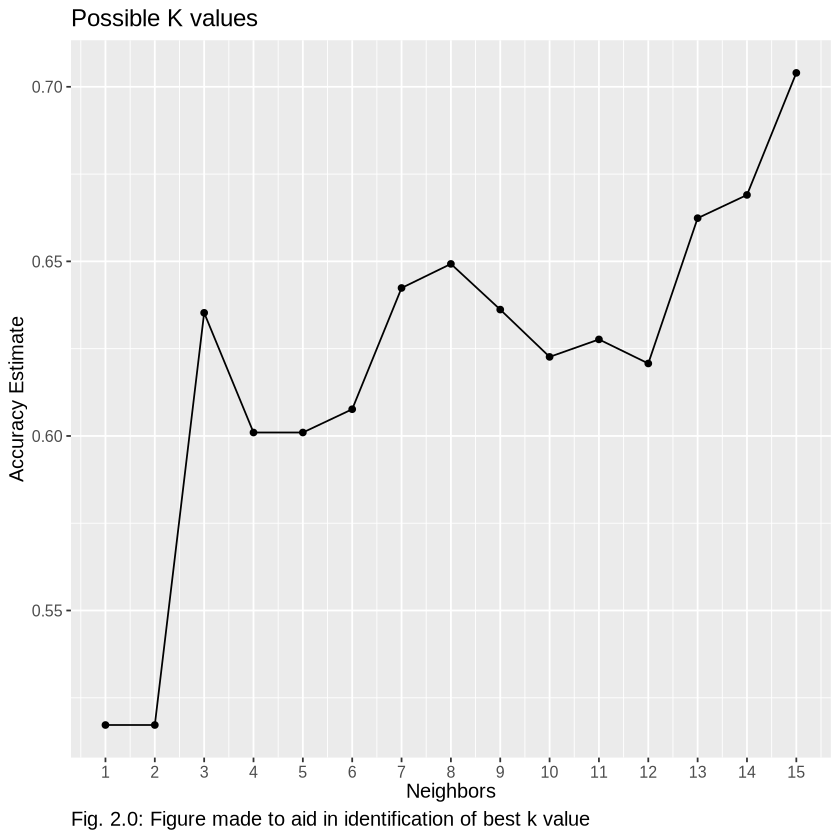

In [75]:
#this cell is for the plot of accuracy vs k to determine the best values of k

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate", title = "Possible K values",
       caption = "Fig. 2.0: Figure made to aid in identification of best k value") +
  theme(text = element_text(size = 12)) +
theme(plot.caption = element_text(size = 12, hjust = 0)) +
  scale_x_continuous(breaks = seq(0, 15, by = 1))
accuracy_vs_k

After determining the best number of neighbours, we can use it to train the model once again and make another workflow. Up until this point, all was achieved using the training dataset. 

We now use the newly trained model to predict the test dataset. We can use these predictions to look at the precision, recall, accuracy, and confusion matrix to determine how good our model is.

In [76]:
set.seed(29)
#use the best k to train the model once again
knn_spec_best <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(knn_recipe) |>
  add_model(knn_spec_best) |>
  fit(data = train_data)

#Use the new trained model to make predictions on the test set, look at its confusion matrix and assess its accuracy, precision, and recall
player_test_predictions <- predict(knn_fit, test_data) |>
  bind_cols(test_data)

player_test_predictions |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")

player_test_predictions |> pull(subscribe) |> levels()

player_test_predictions |>
    precision(truth = subscribe, estimate = .pred_class, event_level = "first")

player_test_predictions |>
    recall(truth = subscribe, estimate = .pred_class, event_level = "first")

confusion <- player_test_predictions |>
             conf_mat(truth = subscribe, estimate = .pred_class)
confusion

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.755102


[1] "FALSE" "TRUE"

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.6666667


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.1538462


          Truth
Prediction FALSE TRUE
     FALSE     2    1
     TRUE     11   35

We can also create a visualization of the models prediction to make it easier to present and asses our model. We can place the visualization of the predictions side by side with the visualization of the original to make it easier for our analysis. Since the predictions were only of the test data, we should make a scatter plot of both the test data (Figure 3.1) and one of the predictions of the labels (Figure 3.0).

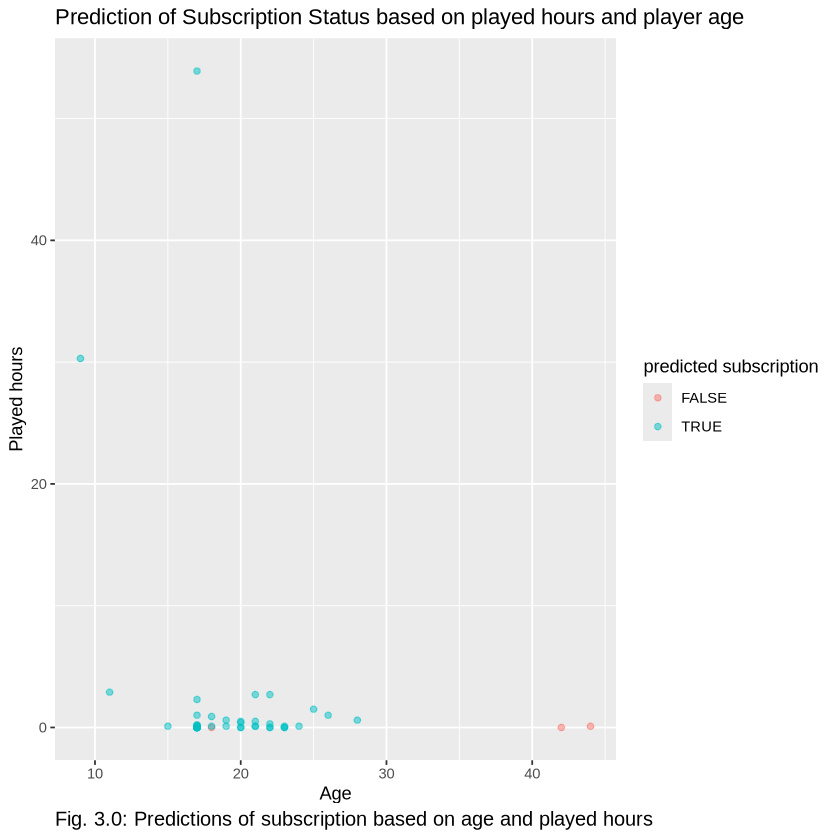

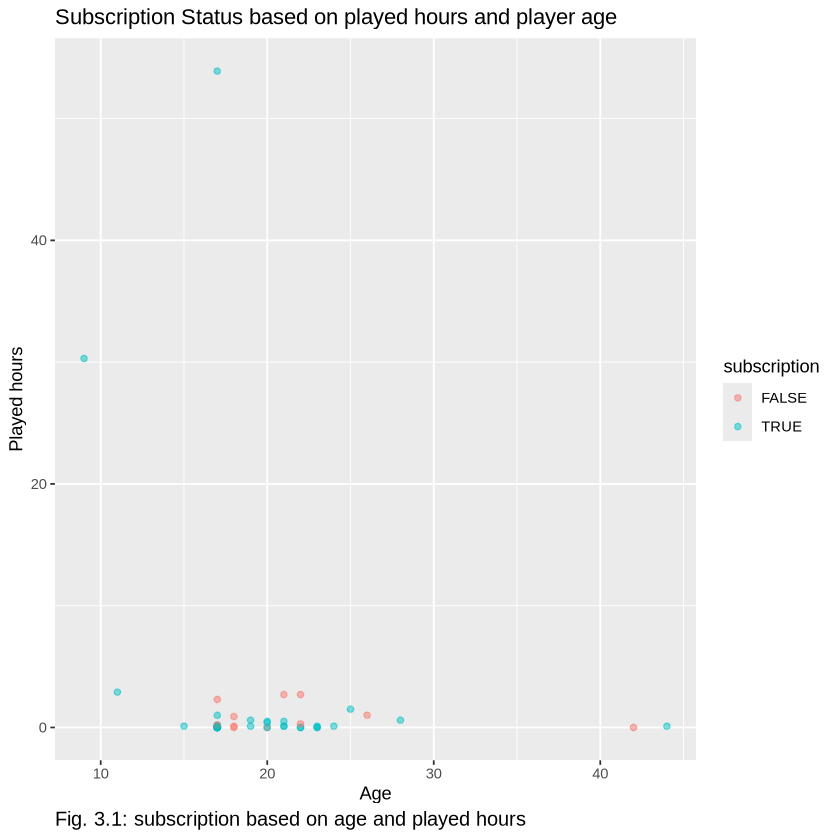

In [84]:
#Show the predictions on a plot, comparing them to the answers.

# ggplot(player_test_predictions, aes(x = subscribe, fill = .pred_class)) +
#   geom_bar(position = "fill") +
#   labs(
#     title = "Actual vs Predicted Subscriptions",
#     x = "Actual Subscription Status",
#     y = "Count",
#     fill = "Predicted", 
#     caption = "Fig. 3.0: Prediction compared to actual subscription status") +
#   theme(plot.caption = element_text(size = 12, hjust = 0))

player_scatter_predictions <- ggplot(player_test_predictions, aes(x = Age, y = played_hours, color = .pred_class)) +
  geom_point(alpha = 0.5) +
  labs(title = "Prediction of Subscription Status based on played hours and player age",
       x = "Age", y = "Played hours", color = "predicted subscription", 
       caption = "Fig. 3.0: Predictions of subscription based on age and played hours") +
theme(plot.caption = element_text(size = 12, hjust = 0))

player_scatter_1 <- ggplot(player_test_predictions, aes(x = Age, y = played_hours, color = subscribe)) +
  geom_point(alpha = 0.5) +
  labs(title = "Subscription Status based on played hours and player age",
       x = "Age", y = "Played hours", color = "subscription", 
       caption = "Fig. 3.1: subscription based on age and played hours") +
theme(plot.caption = element_text(size = 12, hjust = 0))

player_scatter_predictions
player_scatter_1

 **Discussion:**